In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDFsnow\n[mwe $degC^{-1} d^{-1}$]'}

mcmc_output_netcdf_fp = '../MCMC_data/netcdf_trunc/' 
mcmc_output_csv_fp = '../MCMC_data/csv_trunc/' 
mcmc_output_hist_fp = '../MCMC_data/hist_trunc/' 

In [2]:
# load netcdf data
filepath = '../MCMC_data/netcdf_trunc/'
name = '15.00621.nc'
netcdf = filepath+name

ds = xr.open_dataset(filepath + name)

ds

<xarray.Dataset>
Dimensions:   (chain: 3, iter: 30000, mp: 9)
Coordinates:
  * iter      (iter) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * mp        (mp) object 'ddfsnow' 'massbal' 'precfactor' 'tempchange' ...
  * chain     (chain) int64 0 1 2
Data variables:
    mp_value  (iter, mp, chain) float64 ...

In [3]:
def effective_n(ds, vn, iters, burn):
    """
    Compute the effective sample size of a trace.

    Takes the trace and computes the effective sample size
    according to its detrended autocorrelation.

    Parameters
    ----------
    ds : xarray.Dataset
        dataset containing mcmc traces
    vn : str
        Parameter variable name
    iters : int
        number of mcmc iterations to test
    burn : int
        number of initial iterations to throw away

    Returns
    -------
    effective_n : int
        effective sample size
    """
    # Effective sample size
    x = ds['mp_value'].sel(chain=0, mp=vn).values[burn:iters]
    # detrend trace using mean to be consistent with statistics
    # definition of autocorrelation
    x = (x - x.mean())
    # compute autocorrelation (note: only need second half since
    # they are symmetric)
    rho = np.correlate(x, x, mode='full')
    rho = rho[len(rho)//2:]
    # normalize the autocorrelation values
    #  note: rho[0] is the variance * n_samples, so this is consistent
    #  with the statistics definition of autocorrelation on wikipedia
    # (dividing by n_samples gives you the expected value).
    rho_norm = rho / rho[0]
    # Iterate untile sum of consecutive estimates of autocorrelation is
    # negative to avoid issues with the sum being -0.5, which returns an
    # effective_n of infinity
    negative_autocorr = False
    t = 1
    n = len(x)
    while not negative_autocorr and (t < n):
        if not t % 2:
            negative_autocorr = sum(rho_norm[t-1:t+1]) < 0
        t += 1
    return int(n / (1 + 2*rho_norm[1:t].sum()))


def gelman_rubin(ds, vn, iters=1000, burn=0):
    """
    Calculate Gelman-Rubin statistic.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing MCMC iterations for a single glacier with 3 chains
    vn : str
        Parameter variable name
    iters : int
        number of MCMC iterations to test for the gelman-rubin statistic
    burn : int
        number of MCMC iterations to ignore at start of chain before performing test

    Returns
    -------
    gelman_rubin_stat : float
        gelman_rubin statistic (R_hat)
    """
    if len(ds.chain) != 3:
        raise ValueError('Given dataset has an incorrect number of chains')
    if iters > len(ds.mp_value):
        raise ValueError('iters value too high')
    if (burn > iters):
        raise ValueError('Given iters and burn in are incompatible')
    
    # unpack iterations from dataset
    for n_chain in ds.chain.values:
        if n_chain == 0:
            chain = ds['mp_value'].sel(chain=n_chain, mp=vn).values[burn:iters]
            chain = np.reshape(chain, (1,len(chain)))
        else:
            chain2add = ds['mp_value'].sel(chain=n_chain, mp=vn).values[burn:iters]
            chain2add = np.reshape(chain2add, (1,chain.shape[1]))
            chain = np.append(chain, chain2add, axis=0)
    
    #calculate statistics with pymc in-built function
    return pymc.gelman_rubin(chain)

def plot_gelman_rubin(ds, vn, burn_max=5000, burn_step=1000, plot_res=2000):
    """
    Plots the Gelman-Rubin statistic for chains of different lengths
    and with burn-ins ranging from 0 to burn_max, with a step specified
    by brun_step.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing MCMC iterations for a single glacier with 3 chains
    vn : str
        Parameter variable name
    burn_max : int
        Maximum burn-in value to test
    burn_step : int
        Step between different burn values to plot
    plot_res : int
        Frequency of points to calculate gelman_rubin statistic in plot
        (higher number leads to higher plot resolution)
        
    """
    
    fig = plt.figure()
    
    # create a range of burn-in values to try, starting from zero
    # to either 5000 or the number of values in the chain, whichever
    # is less. 1000 iterations steps    
    burn_range = range(0, min(burn_max, len(ds.mp_value)), burn_step)
    
    for burn in burn_range:
        
        # list of points to calculate statistic at
        plot_list = list(range(burn, len(ds.mp_value), plot_res))
        
        print(plot_list)
        
        for pt in plot_list:
            
            # calculate gelman-rubin at each point
            gr_list = [gelman_rubin(ds, vn, pt-burn, burn) for pt in plot_list]

        # plot
        plt.plot(plot_list, gr_list)

def MC_error(ds, vn, iters=None, burn=0, chain_no=0, batches=5):
    """
    Calculates MC Error using the batch simulation method.
    Also returns mean of trace
    
    Calculates the simulation standard error, accounting for non-independent
    samples. The trace is divided into batches, and the standard deviation of
    the batch means is calculated.
    
    With datasets of multiple chains, choses the highest MC error of all
    the chains and returns this value unless a chain number is specified
    
    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing MCMC iterations for a single glacier with 3 chains
    vn : str
        Parameter variable name
    chain_no : int
        Number of chain to use (0,1 ror 2)
        If none, finds the highest MC error of the three chains
        and returns this value
    batches : int
        Number of batches to divide the trace in (default 5)
        
    """ 
    if iters is None:
        iters = len(ds.mp_value)
    
    # get iterations from ds
    trace = [ds['mp_value'].sel(chain=n_chain, mp=vn).values[burn:iters]
             for n_chain in ds.chain.values]
    
    result = batchsd(trace, batches)
    mean = np.mean(trace[chain_no])
    
    if len(ds.chain) <= chain_no or chain_no < 0:

        raise ValueError('Given chain_no is invalid')
    
    else:
        
        return (result[chain_no], mean)
    

        
def batchsd(trace, batches=5):
    """
    Calculates MC Error using the batch simulation method.
    
    Calculates the simulation standard error, accounting for non-independent
    samples. The trace is divided into batches, and the standard deviation of
    the batch means is calculated.
    
    With datasets of multiple chains, choses the highest MC error of all
    the chains and returns this value unless a chain number is specified
    
    Parameters
    ----------
    trace: np.ndarray
        Array representing MCMC chain
    batches : int
        Number of batches to divide the trace in (default 5)
        
    """

    # see if one trace or multiple
    if len(np.shape(trace)) > 1:

        return np.array([batchsd(t, batches) for t in trace])

    else:
        if batches == 1:
            return np.std(trace) / np.sqrt(len(trace))

        try:
            batched_traces = np.resize(trace, (batches, int(len(trace) / batches)))
        except ValueError:
            # If batches do not divide evenly, trim excess samples
            resid = len(trace) % batches
            batched_traces = np.resize(trace[:-resid], 
                (batches, len(trace[:-resid]) / batches))

        means = np.mean(batched_traces, 1)

        return np.std(means) / np.sqrt(batches)
    
def plot_MC_error(ds, vn, plot_res=2000):
    """
    Plots the MC error for chains of different lengths

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing MCMC iterations for a single glacier with 3 chains
    vn : str
        Parameter variable name
    plot_res : int
        Frequency of points to calculate gelman_rubin statistic in plot
        (higher number leads to higher plot resolution)
        
    """
    
    fig = plt.figure()
    
    trace = ds['mp_value'].sel(chain=0, mp=vn).values
        
    # list of points to calculate statistic at
    plot_list = list(range(0, len(ds.mp_value), plot_res))

    print(plot_list)

    for pt in plot_list:

        # calculate gelman-rubin at each point
        mce_list = [MC_error(ds, vn, length=pt) for pt in plot_list]
        
        mean_list = [(np.mean(trace[:pt]) / 100) for pt in plot_list]

    # plot
    plt.plot(plot_list, mce_list)
    plt.plot(plot_list, mean_list)

In [4]:
def plot_mc_results2(netcdf_fn, burns=[0,1000,3000,5000], plot_res=1000):
    """
    Plot gelman-rubin statistic and markov chain error plots.

    Takes the output from the Markov Chain model and plots the results for the mass balance, temperature change,
    precipitation factor, and degree day factor of snow.  Also, outputs the plots associated with the model.

    Parameters
    ----------
    netcdf_fn : str
        Netcdf of MCMC methods with chains of model parameters
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats
    plot_res: int
        Interval of points for which GR and MCerror statistic are calculated.
        (Lower value leads to higher plot resolution)
    glacier_RGIId_float : str
    precfactor_mu : float
        Mean of precipitation factor (default assigned from input)
    tempchange_mu : float
        Mean of temperature change (default assigned from input)
    ddfsnow_mu : float
        Mean of degree day factor of snow (default assigned from input)

    Returns
    -------
    .png files
        Saves two figures of (1) trace, histogram, and autocorrelation, and (2) pair-wise scatter plots.
    """
    # Open dataset
    ds = xr.open_dataset(netcdf_fn)
    
    # get variables and burn length for dimension
    v_len = len(variables)
    b_len = len(burns)
    c_len = len(ds.mp_value)
    no_chains = len(ds.chain)
    

    # ====================== GELMAN-RUBIN PLOTS ===========================

    plt.figure(figsize=(v_len*4, 2))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.suptitle('Gelman-Rubin Statistic vs Number of MCMC Steps', y=1.10)

    for v_count, vn in enumerate(variables):
        
        plt.subplot(1, v_len, v_count+1)

        for b_count, burn in enumerate(burns):

            plot_list = list(range(burn+plot_res, c_len+plot_res, plot_res))
            gr_list = [gelman_rubin(ds, vn, pt, burn) for pt in plot_list]
            
            # plot GR
            plt.plot(plot_list, gr_list, label='Burn-In ' + str(burn))
            
            # plot horizontal line for benchmark
            plt.axhline(1.01, color='black', linestyle='--', linewidth=1)
            
            if v_count == 0:
                plt.ylabel('Gelman-Rubin Value', size=10)
                
            if b_count == 0:
                plt.title(vn_title_dict[vn], size=10)
                
            if v_count == v_len-1:
                plt.legend()
            
            # niceties
            plt.xlabel('Step Number', size=10)
            
    # Save figure                                                                                                       
    #plt.savefig(mcmc_output_figures_fp + glacier_str + '_' + distribution_type + 
     #           '_gelman-rubin' + '_plots_' + str(no_chains) + 'chain_' +  
      #          str(c_len) + 'iter' + '.png', bbox_inches='tight')
            
    # ====================== MC ERROR PLOTS ===========================
    
    plt.figure(figsize=(v_len*4, 2))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.suptitle('MC Error as Percentage of Mean vs Number of MCMC Steps', y=1.10)
    
    for v_count, vn in enumerate(variables):

        plt.subplot(1, v_len, v_count+1)
        
        # points to plot at
        plot_list = list(range(0, c_len+plot_res, plot_res))
        
        # find mean
        total_mean = abs(np.mean(ds['mp_value'].sel(chain=0, mp=vn).values))
        
        mce_list = []
        #mean_list = []
        
        # calculate mc error and mean at each point
        for pt in plot_list:
            
            mce, mean = MC_error(ds, vn, iters=pt)
            mce_list.append(mce)
            #mean_list.append(abs(mean) / 100)

        # plot
        plt.plot(plot_list, mce_list / (total_mean / 100))
        plt.axhline(1, color='orange', label='1% of Mean', linestyle='--')
        plt.axhline(3, color='green', label='3% of Mean', linestyle='--')
        
        if v_count == 0:
            plt.ylabel('MC Error [% of mean]', size=10)
            
        if v_count == v_len-1:
            plt.legend()

        # niceties
        plt.xlabel('Step Number', size=10)
        plt.title(vn_title_dict[vn], size=10)
        
    # Save figure                                                                                                       
    #plt.savefig(mcmc_output_figures_fp + glacier_str + '_' + distribution_type + 
     #           '_mc-error' + '_plots_' + str(no_chains) + 'chain_' +  
       #         str(c_len) + 'iter' + '.png', bbox_inches='tight')
    
    # ====================== EFFECTIVE_N PLOTS ===========================
    
    plt.figure(figsize=(v_len*4, 2))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.suptitle('Effective Sample Size vs Number of MCMC Steps', y=1.10)
    
    # get dataframe
    df = ds['mp_value'].sel(chain=0).to_pandas()

    for v_count, vn in enumerate(variables):
        
        plt.subplot(1, v_len, v_count+1)

        for b_count, burn in enumerate(burns):

            # points to plot at
            plot_list = list(range(burn+plot_res, c_len+plot_res, plot_res))
            en_list = [effective_n(ds, vn=vn, iters=pt, burn=burn) for pt in plot_list]

            # plot
            plt.plot(plot_list, en_list, label='Burn-In ' + str(burn))

            if v_count == 0:
                plt.ylabel('Effective Sample Size', size=10)

            if v_count == v_len-1:
                plt.legend()
                
            if b_count == 0:
                plt.title(vn_title_dict[vn], size=10)
            
            # niceties
            plt.xlabel('Step Number', size=10)
            
    # Save figure                                                                                                       
    #plt.savefig(mcmc_output_figures_fp + glacier_str + '_' + distribution_type + 
     #           '_effective-n' + '_plots_' + str(no_chains) + 'chain_' +  
       #         str(c_len) + 'iter' + '.png', bbox_inches='tight')

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


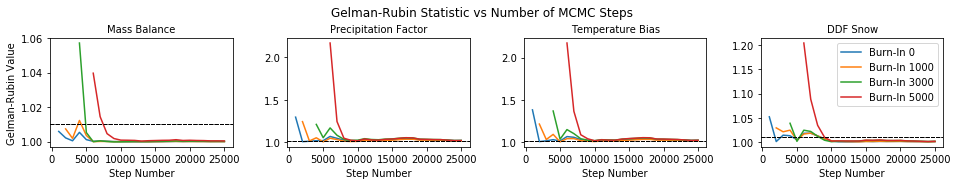

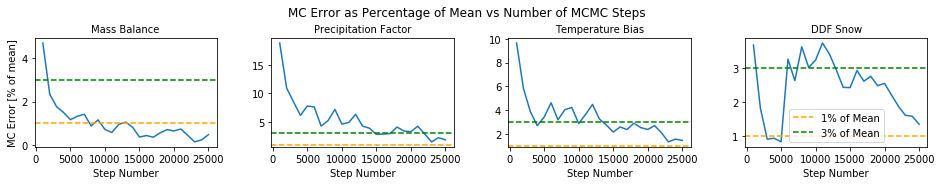

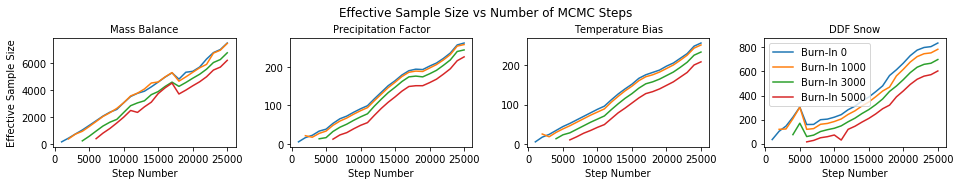

In [6]:
plot_mc_results2(netcdf)

In [5]:
def summary(netcdf, iters=[5000, 10000, 25000], alpha=0.05, start=0,
            batches=100, chain=None, roundto=3, filename='output.txt'):
        """
        Generate a pretty-printed summary of the mcmc chain for different
        chain lengths.
        
        Parameters
        ----------
        netcdf : str
            filepath of netcdf output file of mcmc process
        alpha : float
            The alpha level for generating posterior intervals. Defaults to
            0.05.
        start : int
          The starting index from which to summarize (each) chain. Defaults
          to zero.
        batches : int
          Batch size for calculating standard deviation for non-independent
          samples. Defaults to 100.
        chain : int
          The index for which chain to summarize. Defaults to None (all
          chains).
        roundto : int
          The number of digits to round posterior statistics.
        filename : str
            Name of the text

        Returns
        -------
        .txt file
            Summary statistics printed out to a text file of given name
        """
        # open dataset
        ds = xr.open_dataset(netcdf)
        
        # open file to write to
        file = open(filename, 'w')
        
        for iteration in iters:
        
            print('\n%s:' % (str(iteration) + ' iterations'), file=file)

            for vn in variables:

                # get trace from database
                trace = ds['mp_value'].sel(chain=0, mp=vn).values[:]

                # Calculate statistics for Node
                statdict = stats(
                    trace,
                    alpha=alpha,
                    start=start,
                    batches=batches,
                    chain=chain)

                size = np.size(statdict['mean'])

                print('\n%s:' % vn, file=file)
                print(' ', file=file)

                # Initialize buffer
                buffer = []

                # Index to interval label
                iindex = [key.split()[-1] for key in statdict.keys()].index('interval')
                interval = list(statdict.keys())[iindex]

                # Print basic stats
                buffer += [
                    'Mean             SD               MC Error        %s' %
                    interval]
                buffer += ['-' * len(buffer[-1])]

                indices = range(size)
                if len(indices) == 1:
                    indices = [None]

                _format_str = lambda x, i=None, roundto=2: str(np.round(x.ravel()[i].squeeze(), roundto))

                for index in indices:
                    # Extract statistics and convert to string
                    m = _format_str(statdict['mean'], index, roundto)
                    sd = _format_str(statdict['standard deviation'], index, roundto)
                    mce = _format_str(statdict['mc error'], index, roundto)
                    hpd = str(statdict[interval].reshape(
                            (2, size))[:,index].squeeze().round(roundto))

                    # Build up string buffer of values
                    valstr = m
                    valstr += ' ' * (17 - len(m)) + sd
                    valstr += ' ' * (17 - len(sd)) + mce
                    valstr += ' ' * (len(buffer[-1]) - len(valstr) - len(hpd)) + hpd

                    buffer += [valstr]

                buffer += [''] * 2

                # Print quantiles
                buffer += ['Posterior quantiles:', '']

                buffer += [
                    '2.5             25              50              75             97.5']
                buffer += [
                    ' |---------------|===============|===============|---------------|']

                for index in indices:
                    quantile_str = ''
                    for i, q in enumerate((2.5, 25, 50, 75, 97.5)):
                        qstr = _format_str(statdict['quantiles'][q], index, roundto)
                        quantile_str += qstr + ' ' * (17 - i - len(qstr))
                    buffer += [quantile_str.strip()]

                buffer += ['']

                print_('\t' + '\n\t'.join(buffer), file=file)
        
        file.close()

        
def stats(trace, alpha=0.05, start=0, batches=100,
              chain=None, quantiles=(2.5, 25, 50, 75, 97.5)):
        """
        Generate posterior statistics for node.
        
        Parameters
        ----------
        trace : numpy.ndarray
            single dimension array containing mcmc iterations
        alpha : float
          The alpha level for generating posterior intervals. Defaults to
          0.05.
        start : int
          The starting index from which to summarize (each) chain. Defaults
          to zero.
        batches : int
          Batch size for calculating standard deviation for non-independent
          samples. Defaults to 100.
        chain : int
          The index for which chain to summarize. Defaults to None (all
          chains).
        quantiles : tuple or list
          The desired quantiles to be calculated. Defaults to (2.5, 25, 50, 75, 97.5).

        Returns
        -------
        statdict : dict
            dict containing the following statistics of the trace (with the same key names)
            
            'n': length of mcmc chain
            'standard deviation': 
            'mean':
            '%s%s HPD interval' % (int(100 * (1 - alpha)), '%'): utils.hpd(trace, alpha),
            'mc error':
            'quantiles':

        """
        
        n = len(trace)

        return {
            'n': n,
            'standard deviation': trace.std(0),
            'mean': trace.mean(0),
            '%s%s HPD interval' % (int(100 * (1 - alpha)), '%'): utils.hpd(trace, alpha),
            'mc error': base.batchsd(trace, min(n, batches)),
            'quantiles': utils.quantiles(trace, qlist=quantiles)
        }

In [6]:
def write_table(region_no=15, iters=1000, burn=0):
    '''
    Writes a csv table that lists MCMC assessment values for
    each glacier (represented by a netcdf file.
    
    Writes out the values of effective_n (autocorrelation with
    lag 100), Gelman-Rubin Statistic, MC_error.
    
    Parameters
    ----------
    region_no : int
        number of the glacier region (13, 14 or 15)
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    dfs : list of pandas.DataFrame
        dataframes containing statistical information for all glaciers
    .csv files
        Saves tables to csv file.
        
    '''
    
    dfs=[]
    
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow'] 
    
    # find all netcdf files (representing glaciers)
    filelist = glob.glob(mcmc_output_netcdf_fp + str(region_no) + '*.nc')
    
    for vn in variables:
    
        # create lists of each value
        glac_no = []
        effective_n_list = []
        gelman_rubin_list = []
        mc_error = []


        # iterate through each glacier
        for netcdf in filelist:
            print(netcdf)
            # open dataset
            ds = xr.open_dataset(netcdf)

            # find values for this glacier and append to lists
            glac_no.append(netcdf[-11:-3])

            effective_n_list.append(effective_n(ds, vn=vn, iters=iters, burn=burn))
            gelman_rubin_list.append(gelman_rubin(ds, vn=vn, iters=iters, burn=burn))
            mc_error.append(MC_error(ds, vn=vn, iters=iters, burn=burn)[0])

            ds.close()

        mean = abs(np.mean(mc_error))
        mc_error /= mean

        # create dataframe
        data = {'Glacier': glac_no,
                'Effective N' : effective_n_list,
                'MC Error' : mc_error,
                'Gelman-Rubin' : gelman_rubin_list}
        df = pd.DataFrame(data)
        df.set_index('Glacier', inplace=True)
        #df = pd.DataFrame(data, index = {'Glacier': glac_no})

        # save csv
        df.to_csv(mcmc_output_csv_fp + 'region' + str(region_no) + '_' +
                  str(iters) + 'iterations_' + str(burn) + 'burn_' + str(vn) + '.csv')
        
        dfs.append(df)
    
    return dfs

In [7]:
def plot_histograms(vn, iters, burn, df=None):
    '''
    Plots histograms to assess mcmc chains for groups of glaciers
    
    Plots histograms of effective_n, gelman-rubin and mc error for
    the given number of iterations and burn-in and the given variable.
    
    For this function to work, the appropriate csv file must have already
    been created.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe containing glacier information to be plotted. If 
        none, looks for appropriate csv file
    vn : str
        Name of variable (massbal, ddfsnow, precfactor, tempchange)
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .png files
        Saves images to 3 png files.
        
    '''
    
    
    # if df not given, look for csv file. Will throw an error
    # if appropriately named csv does not exist
    if df is None:
        df = pd.read_csv(mcmc_output_csv_fp + str(iters) + 'iterations_'
                         + str(burn) + 'burn_' + str(vn) + '.csv')
        #df.set_index('Glacier', inplace=True)
        
    # ====================== GELMAN-RUBIN HISTOGRAM ========================
    
    fig = plt.figure()
    
    n, bins, patches = plt.hist(x=df['Gelman-Rubin'], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    #plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Gelman-Rubin Value')
    plt.ylabel('Frequency')
    
    # niceties
    plt.title('Gelman-Rubin Statistic: ' + str(iters) + ' iterations ' +
              str(burn) + ' burn-in')

    plt.xticks()
    plt.yticks()
    
    
    # ====================== MC ERROR HISTOGRAM ===========================
    
    fig = plt.figure()
    plt.hist(df['MC Error'])
    
    # niceties
    plt.title('MC Error: ' + str(iters) + ' iterations ' +
              str(burn) + ' burn-in')
    #plt.ylabel('Glacier Volume (Cubic km)')
    #plt.xlabel('Year')

    plt.xticks()
    plt.yticks()
    
    # ====================== EFFECTIVE N HISTOGRAM ===========================
    
    
    fig = plt.figure()
    plt.hist(df['Effective N'])
    
    # niceties
    plt.title('Effective N: ' + str(iters) + ' iterations ' +
              str(burn) + ' burn-in')
        

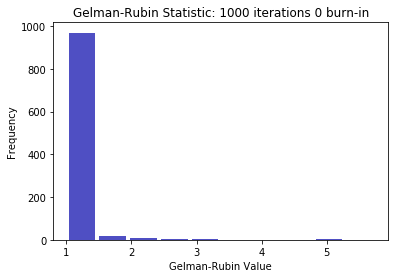

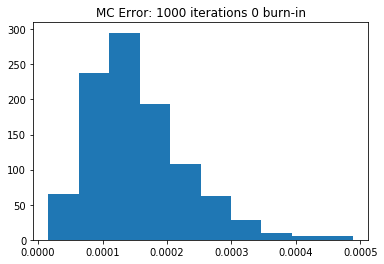

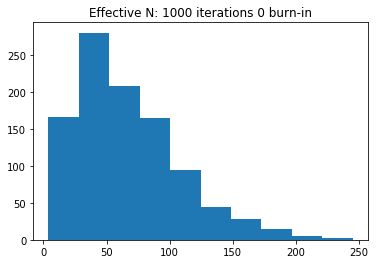

In [8]:
plot_histograms('massbal', iters=1000, burn=0, df=df)

In [8]:
def plot_histograms(iters, burn, region=15, dfs=None):
    '''
    Plots histograms to assess mcmc chains for groups of glaciers
    
    Plots histograms of effective_n, gelman-rubin and mc error for
    the given number of iterations and burn-in and the given variable.
    
    For this function to work, the appropriate csv file must have already
    been created.
    
    Parameters
    ----------
    dfs : list of pandas.DataFrame
        list of dataframes containing glacier information to be plotted. If 
        none, looks for appropriate csv file
    vn : str
        Name of variable (massbal, ddfsnow, precfactor, tempchange)
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .png files
        Saves images to 3 png files.
        
    '''
    
    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
    vn_title_dict = {'massbal':'Mass Balance',                                                                      
                     'precfactor':'Precipitation Factor',                                                              
                     'tempchange':'Temperature Bias',                                                               
                     'ddfsnow':'DDF Snow'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
    
    vn_df_dict = {}
    
    # read csv files
    for vn in variables:
        vn_df_dict[vn] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                     str(region) + '_' + str(iters) +
                                     'iterations_' + str(burn) + 'burn_' +
                                     str(vn) + '.csv')

    
    # get variables and burn length for dimension
    v_len = len(variables)
    
    # create plot for each metric
    for metric in metrics:
        
        plt.figure(figsize=(v_len*4, 2))
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        
        if metric=='MC Error':
            plt.suptitle(metric + ' (as percentage of mean) Histrogram ' +
                         str(iters) + ' iterations ' + str(burn) + ' burn-in', y=1.15,
                         fontsize=14)
        else:
            plt.suptitle(metric + ' Histrogram ' +
                         str(iters) + ' iterations ' + str(burn) + ' burn-in', y=1.15,
                         fontsize=14)
        
        # create subplot for each variable
        for v_count, vn in enumerate(variables):
            
            df = vn_df_dict[vn]
            
            # plot histogram
            plt.subplot(1, v_len, v_count+1)
            n, bins, patches = plt.hist(x=df[metric], bins=30, alpha=.4, edgecolor='black',
                                        color='#0504aa')
            
            
            # niceties
            plt.title(vn_title_dict[vn])

            if v_count == 0:
                plt.ylabel('Frequency')
            
            
        # Save figure                                                                                                       
        plt.savefig(mcmc_output_hist_fp + 'region' + str(region) + '_' + str(iters) +
                    'iterations_' + str(burn) + 'burn_' + str(metric) + '.png')

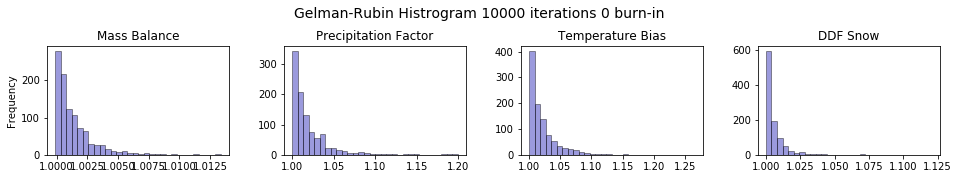

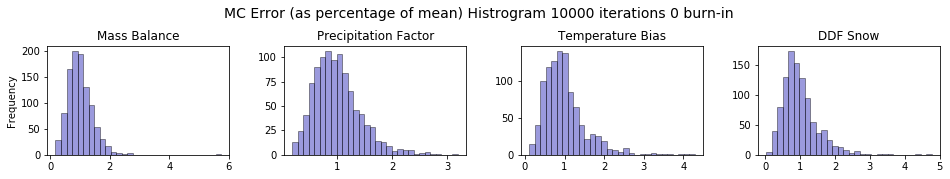

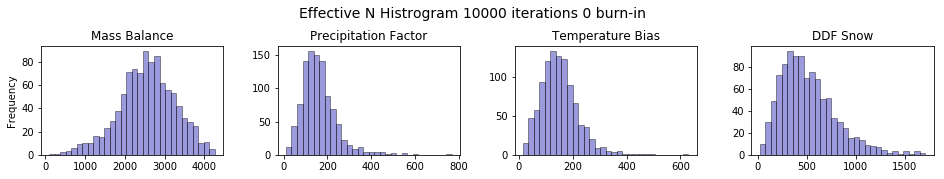

In [82]:
plot_histograms(iters=10000, burn=0)

In [9]:
def plot_histograms_2(iters, burn, region=15, dfs=None):
    '''
    Plots histograms to assess mcmc chains for groups of glaciers.
    Puts them all in one image file.
    
    Plots histograms of effective_n, gelman-rubin and mc error for
    the given number of iterations and burn-in and the given variable.
    
    For this function to work, the appropriate csv file must have already
    been created.
    
    Parameters
    ----------
    dfs : list of pandas.DataFrame
        list of dataframes containing glacier information to be plotted. If 
        none, looks for appropriate csv file
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .png files
        Saves images to 3 png files.
        
    '''
    
    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
    vn_title_dict = {'massbal':'Mass Balance',                                                                      
                     'precfactor':'Precipitation Factor',                                                              
                     'tempchange':'Temperature Bias',                                                               
                     'ddfsnow':'DDF Snow'}
    
    test = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                     str(region) + '_' + str(iters) +
                                     'iterations_' + str(burn) + 'burn_' +
                                     str('massbal') + '.csv')
   
    # determine whether Gelman-Rubin has been computed
    if 'Gelman-Rubin' in test.columns:
        metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
    else:
        metrics = ['MC Error', 'Effective N']
    
    vn_df_dict = {}
    
    # hard code font sizes
    ticks=10
    suptitle=16
    title=14
    label=12
    plotline=3
    legend=10
    
    # bins and ticks
    if iters==15000:
        tbins = np.arange(1.00, 1.06, 0.002)
        pbins = np.arange(1.0, 1.006, 0.0002)
        dbins = np.arange(1.0, 1.006, 0.0002)
        mbins = np.arange(1.0, 1.006, 0.0002)
        mcbins = np.arange(0, 3, 0.1)
        grticks = np.arange(0, 30, 5)
        mcticks = np.arange(0, 19, 4)
        nticks = np.arange(0, 19, 4) 
    else:
        tbins = np.arange(1.00, 1.12, 0.004)
        pbins = np.arange(1.00, 1.12, 0.004)
        dbins = np.arange(1, 1.018, 0.006)
        mbins = np.arange(1, 1.012, 0.0004)
        mcbins = np.arange(0, 4, 0.125)
        grticks = np.arange(0, 30, 5)
        mcticks = np.arange(0, 19, 4)
        nticks = np.arange(0, 19, 4)

    
    # read csv files
    for vn in variables:
        vn_df_dict[vn] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                     str(region) + '_' + str(iters) +
                                     'iterations_' + str(burn) + 'burn_' +
                                     str(vn) + '.csv')
 
    # get variables and burn length for dimension
    v_len = len(variables)
    m_len = len(metrics)
        
    # create figure
    #fig=plt.figure(figsize=(6.5, 4))
    fig = plt.figure(figsize=(v_len*5, m_len*3.5), dpi=72)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    # write title
    plt.suptitle('MC Metrics Assessment Histograms ' +
                 str(iters) + ' iterations ' + str(burn) + ' burn-in',
                 fontsize=18, y=0.97)

    #create subplot for each metric
    for m_count, metric in enumerate(metrics):

        # create subplot for each variable
        for v_count, vn in enumerate(variables):

            df = vn_df_dict[vn]

            # plot histogram
            ax = plt.subplot(m_len, v_len, v_len*m_count+v_count+1)
            ax2 = ax.twinx()
            
            # create uniform bins based on matric
            if metric == 'Gelman-Rubin':
                if vn == 'tempchange':
                    bins = tbins
                elif vn == 'precfactor':
                    bins = pbins
                elif vn == 'ddfsnow':
                    bins = dbins
                elif vn == 'massbal':
                    bins = mbins
            elif metric == 'MC Error':
                bins = mcbins
            elif metric == 'Effective N':
                bins = 30
                
            #print('bins: ', bins)
                
            # compute histogram and change to percentage of glaciers
            hist, bins = np.histogram(a=df[metric], bins=bins)
            hist = hist * 100.0 / hist.sum()

            # plot histogram
            ax.bar(x=bins[1:], height=hist, width=(bins[1]-bins[0]), align='center',
                   alpha=.4, edgecolor='black', color='#0504aa')
            
            # create uniform bins based on metric
            if metric == 'Gelman-Rubin':
                ax.set_yticks(grticks)
            elif metric == 'MC Error':
                ax.set_yticks(mcticks)
            elif metric == 'Effective N':
                ax.set_yticks(nticks)
            
            # find cumulative percentage and plot it
            cum_hist = [hist[0:i].sum() for i in range(len(hist))]            
            ax2.plot(bins[:-1], cum_hist, color='#ff6600',
                     linewidth=plotline, label='Cumulative\nPercentage')
            ax2.set_yticks(np.arange(0, 110, 20))
            
            # set tick sizes
            ax.tick_params(labelsize=ticks)
            ax2.tick_params(labelsize=ticks)
            
            # niceties
            if m_count == 0:
                plt.title(vn_title_dict[vn], fontsize=title)    

            # axis labels
            if v_count == 0:
                ax.set_ylabel('Percentage of Glaciers [%]', fontsize=label, labelpad=10)
            if v_count ==3:
                ax2.set_ylabel('Cumulative Percentage [%]', fontsize=label, rotation = 270, labelpad=35)
            if metric=='MC Error':
                ax.set_xlabel(metric + ' (as percentage of mean)', fontsize=label)
            else:
                ax.set_xlabel(metric + ' value', fontsize=label)
                
            # legend
            if v_count==3 and m_count==0:
                ax2.legend(loc='center right', fontsize=legend)
                          
    print(fig.get_size_inches())
    
    # Save figure                                                                                                       
    plt.savefig(mcmc_output_hist_fp + 'region' + str(region) + '_' + str(iters) +
                'iterations_' + str(burn) + 'burn_all.png')

[ 20.   10.5]


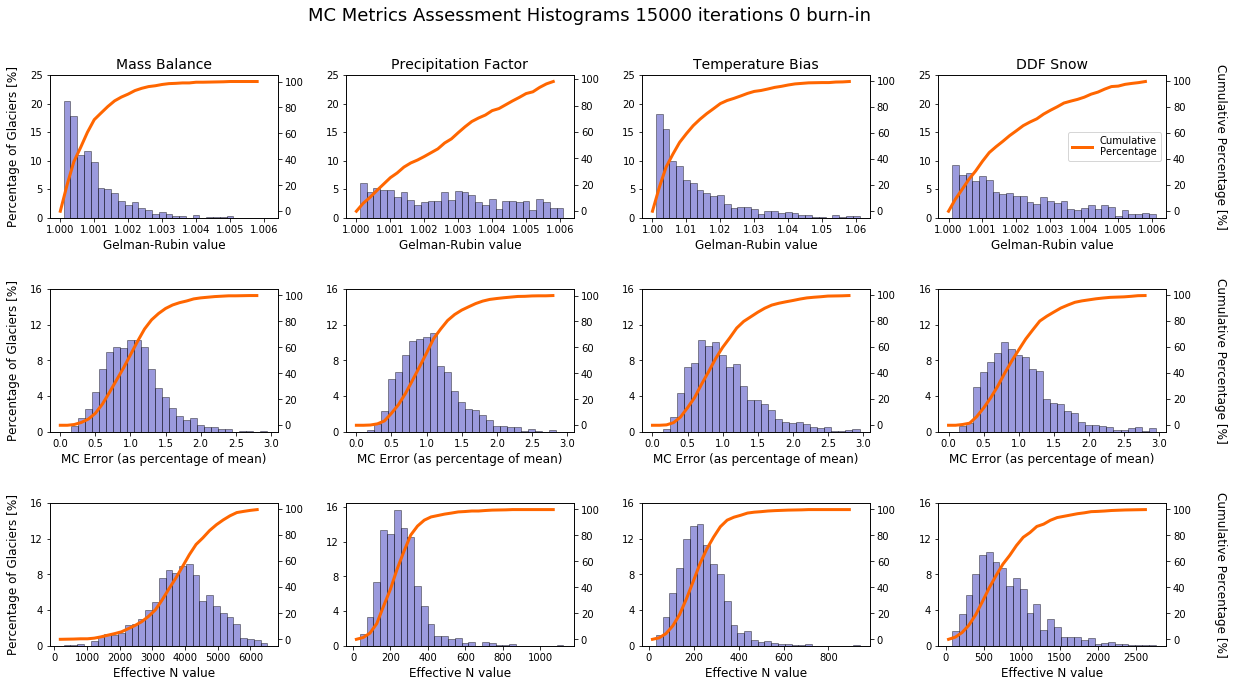

In [274]:
plot_histograms_2(iters=15000, burn=0)

In [41]:
np.arange(0, 10, 1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [218]:
print(mpl.rcParams['figure.figsize'], mpl.rcParams['figure.dpi'],
      mpl.rcParams['savefig.dpi'], mpl.rcParams['font.size'],
      mpl.rcParams['legend.fontsize'], mpl.rcParams['figure.titlesize'])

[6.0, 4.0] 72.0 figure 10.0 medium large


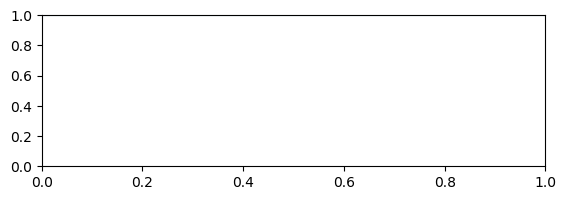

In [21]:
plt.figure(figsize=(6.5, 2), dpi=100)
plt.axhline(1)
plt.savefig('../../Desktop/text.png')

In [10]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDFsnow\n[mwe $degC^{-1} d^{-1}$]'}

suffix = '_trunc'
mcmc_output_netcdf_fp = '../MCMC_data/netcdf' + suffix + '/'
mcmc_output_figures_fp = '../MCMC_data/figures' + suffix + '/'
mcmc_output_tables_fp = '../MCMC_data/tables/'
mcmc_output_csv_fp = '../MCMC_data/csv' + suffix + '/'
mcmc_output_hist_fp = '../MCMC_data/hist' + suffix + '/'

In [11]:
def write_table2(iters, region='all', burn=0):
    '''
    Writes a csv table that lists mean MCMC assessment values for
    each glacier (represented by a netcdf file) for all glaciers at
    different chain lengths.

    Writes out the values of effective_n (autocorrelation with
    lag 100), Gelman-Rubin Statistic, MC_error.

    Parameters
    ----------
    region : int
        number of the glacier region (13, 14 or 15)
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .csv files
        Saves tables to csv file.

    '''

    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']

    # find all netcdf files (representing glaciers)
    if region == 'all':
        regions = ['13', '14', '15']
        filelist = []
        for reg in regions:
            filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
    else:
        filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')
        
    # for testing
    filelist = filelist[0:3]

    for vn in variables:

        # create lists of each value
        glac_no = []
        effective_n_list = []
        gelman_rubin_list = []
        mc_error = []


        # iterate through each glacier
        for netcdf in filelist:
            print(netcdf)

           # try:
            # open dataset
            ds = xr.open_dataset(netcdf)

            # calculate metrics
            en = [effective_n(ds, vn=vn, iters=i, burn=burn) for i in iters]
            mc = [MC_error(ds, vn=vn, iters=i, burn=burn)[0] for i in iters]
            if len(ds.chain) > 1:
                gr = [gelman_rubin(ds, vn=vn, iters=i, burn=burn) for i in iters]

            # find values for this glacier and append to lists
            glac_no.append(netcdf[-11:-3])
            effective_n_list.append(en)
            # test if multiple chains exist
            if len(ds.chain) > 1:
                gelman_rubin_list.append(gr)

            # divide MC Error by the mean values
            print('ok')
            mean = np.mean(ds['mp_value'].sel(chain=n_chain, mp=vn).values)
            mc /= mean
            mc_error.append(mc)

            ds.close()

            #except:
                #print('Error, glacier: ', netcdf)
                #pass
            
        # do averaging operations
        print(effective_n_list)
        effective_n_list = np.mean(effective_n_list, axis=0)
        gelman_rubin_list = np.mean(gelman_rubin_list, axis=0)
        mc_error = np.mean(mc_error, axis=0)

        # create dataframe
        data = {'Iter': iters,
                'Effective N' : effective_n_list,
                'MC Error' : mc_error}
        if len(gelman_rubin_list) > 0:
            data['Gelman-Rubin'] = gelman_rubin_list
        df = pd.DataFrame(data)
        df.set_index('Iter', inplace=True)

        # save csv
        df.to_csv(mcmc_output_csv_fp + 'assessment_plot_' + str(region) + 'region_' +
                  str(iters) + 'iterations_' + str(burn) + 'burn_' + str(vn) + '.csv')

In [14]:
burn = 0
iters = np.arange(1000, 31000, 3000)                                                                               
iters = np.append(iterations, 30000)
region='all'

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']

# find all netcdf files (representing glaciers)
if region == 'all':
    regions = ['13', '14', '15']
    filelist = []
    for reg in regions:
        filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
else:
    filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')

# for testing
filelist = filelist[0:3]

for vn in variables:

    # create lists of each value
    glac_no = []
    effective_n_list = []
    gelman_rubin_list = []
    mc_error = []

    # iterate through each glacier
    for netcdf in filelist:
        print(netcdf)

       # try:
        # open dataset
        ds = xr.open_dataset(netcdf)

        # calculate metrics
        en = [effective_n(ds, vn=vn, iters=i, burn=burn) for i in iters]
        mc = [MC_error(ds, vn=vn, iters=i, burn=burn)[0] for i in iters]
        if len(ds.chain) > 1:
            gr = [gelman_rubin(ds, vn=vn, iters=i, burn=burn) for i in iters]

        # find values for this glacier and append to lists
        glac_no.append(netcdf[-11:-3])
        effective_n_list.append(en)
        # test if multiple chains exist
        if len(ds.chain) > 1:
            gelman_rubin_list.append(gr)
        mc_error.append(mc)

../MCMC_data/netcdf_trunc/13.54209.nc
../MCMC_data/netcdf_trunc/13.14191.nc
../MCMC_data/netcdf_trunc/13.42130.nc
../MCMC_data/netcdf_trunc/13.54209.nc
../MCMC_data/netcdf_trunc/13.14191.nc
../MCMC_data/netcdf_trunc/13.42130.nc
../MCMC_data/netcdf_trunc/13.54209.nc
../MCMC_data/netcdf_trunc/13.14191.nc
../MCMC_data/netcdf_trunc/13.42130.nc
../MCMC_data/netcdf_trunc/13.54209.nc
../MCMC_data/netcdf_trunc/13.14191.nc
../MCMC_data/netcdf_trunc/13.42130.nc


In [15]:
effective_n_list

[[80, 271, 423, 635, 897, 1120, 1359, 1589, 1818, 2079, 2220, 2220],
 [47, 225, 404, 644, 896, 1135, 1364, 1646, 1826, 2042, 2164, 2164],
 [120, 531, 972, 1457, 1809, 2310, 2728, 3039, 3406, 3806, 3883, 3883]]

In [21]:
df = pd.DataFrame(effective_n_list, index=glac_no, columns=iters)

In [17]:
glac_no

['13.54209', '13.14191', '13.42130']

In [22]:
df.columns

Int64Index([1000, 4000, 7000, 10000, 13000, 16000, 19000, 22000, 25000, 28000,
            30000, 30000],
           dtype='int64')

In [24]:
df

,1000,4000,7000,10000,13000,16000,19000,22000,25000,28000,30000,30000
13.54209,80,271,423,635,897,1120,1359,1589,1818,2079,2220,2220
13.14191,47,225,404,644,896,1135,1364,1646,1826,2042,2164,2164
13.42130,120,531,972,1457,1809,2310,2728,3039,3406,3806,3883,3883


In [35]:
df.quantile(q=0.05)

1000       50.3
4000      229.6
7000      405.9
10000     635.9
13000     896.1
16000    1121.5
19000    1359.5
22000    1594.7
25000    1818.8
28000    2045.7
30000    2169.6
30000    2169.6
Name: 0.05, dtype: float64